In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

prices = pd.read_csv("/content/drive/MyDrive/Daily Prices_ICCO.csv")
print(prices.columns)

prices['Date'] = pd.to_datetime(prices['Date'], dayfirst=True)

prices['Price'] = pd.to_numeric(
    prices['ICCO daily price (US$/tonne)'].str.replace(",", "", regex=False)
)


prices = prices[['Date', 'Price']].sort_values('Date')


# prices['Price'] = prices['Price'].fillna(method='ffill').fillna(method='bfill')
# prices['Price'] = prices['Price'].fillna(prices['Price'].mean())
prices['Price'] = prices['Price'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

weather = pd.read_csv("/content/drive/MyDrive/Ghana_data.csv")


weather['DATE'] = pd.to_datetime(weather['DATE'])


weather['PRCP'] = weather['PRCP'].fillna(0)


# weather['TAVG'] = weather['TAVG'].interpolate(method='linear')
# weather['TMAX'] = weather['TMAX'].interpolate(method='linear')
# weather['TMIN'] = weather['TMIN'].interpolate(method='linear')
for col in ['TAVG', 'TMAX', 'TMIN']:
    weather[col] = weather[col].interpolate(method='linear')\
                               .fillna(method='ffill')\
                               .fillna(method='bfill')


weather = weather.groupby('DATE').agg({
    'PRCP': 'mean',
    'TAVG': 'mean',
    'TMAX': 'mean',
    'TMIN': 'mean'
}).reset_index()


merged_data = pd.merge(prices, weather, how='left', left_on='Date', right_on='DATE')
print(len(merged_data))
merged_data = merged_data.drop(columns=['DATE'])
merged_data = merged_data.dropna()
print(len(merged_data))

merged_data.to_csv("cleaned_cocoa_data.csv", index=False)

Index(['Date', 'ICCO daily price (US$/tonne)'], dtype='object')


<ipython-input-2-8ed15ae55c0c>:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  prices['Price'] = prices['Price'].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


7812
6670


<ipython-input-2-8ed15ae55c0c>:34: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='ffill')\
<ipython-input-2-8ed15ae55c0c>:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  .fillna(method='bfill')


In [3]:
import pandas as pd

df = pd.read_csv("cleaned_cocoa_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').resample('D').mean().dropna().reset_index()

cutoff_date = df['Date'].max() - pd.DateOffset(months=4)
train_df = df[df['Date'] < cutoff_date].reset_index(drop=True)
test_df = df[df['Date'] >= cutoff_date].reset_index(drop=True)

print(f"Train: {train_df['Date'].min()} → {train_df['Date'].max()},{len(train_df)} ")
print(f"Test : {test_df['Date'].min()} → {test_df['Date'].max()},{len(test_df)} ")

Train: 1994-10-03 00:00:00 → 2024-07-26 00:00:00,6582 
Test : 2024-07-29 00:00:00 → 2024-11-28 00:00:00,84 


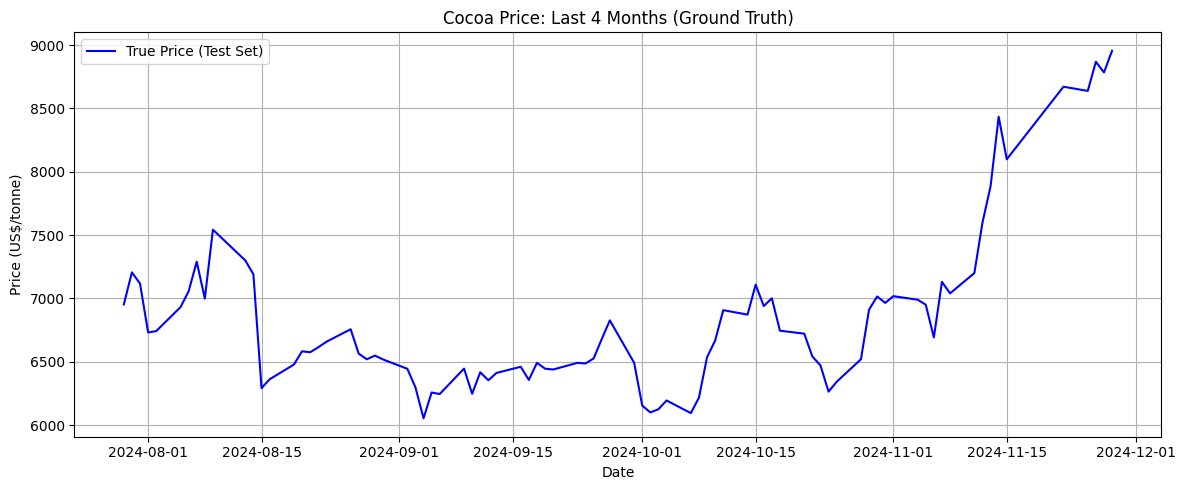

In [4]:
import matplotlib.pyplot as plt

dates = test_df['Date']
prices = test_df['Price']

plt.figure(figsize=(12, 5))
plt.plot(dates, prices, label='True Price (Test Set)', color='blue')
plt.title("Cocoa Price: Last 4 Months (Ground Truth)")
plt.xlabel("Date")
plt.ylabel("Price (US$/tonne)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
import numpy as np

features = ['Price', 'PRCP', 'TAVG', 'TMAX', 'TMIN']
lag = 7

X_train, y_train = [], []
train_array = train_df[features].values

for i in range(lag, len(train_array)):
    window = train_array[i-lag:i].flatten()
    target = train_array[i][0]
    X_train.append(window)
    y_train.append(target)

X_train = np.array(X_train)
y_train = np.array(y_train)


In [81]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X_tensor.shape[1])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.0072
Epoch 10, Loss: 0.0065
Epoch 20, Loss: 0.0037
Epoch 30, Loss: 0.0026
Epoch 40, Loss: 0.0062
Epoch 50, Loss: 0.0020
Epoch 60, Loss: 0.0068
Epoch 70, Loss: 0.0045
Epoch 80, Loss: 0.0012
Epoch 90, Loss: 0.0006


In [84]:
model.eval()

test_array = test_df[features].values
history = train_df[features].values[-lag:].tolist()

preds = []

with torch.no_grad():
    for i in range(len(test_array)):
        window_input = np.array(history).flatten().reshape(1, -1)
        window_input_scaled = scaler_X.transform(window_input)

        x_tensor = torch.tensor(window_input_scaled, dtype=torch.float32)
        y_pred_scaled = model(x_tensor).numpy()
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0, 0]
        preds.append(y_pred)

        today_weather = test_array[i][1:]
        next_row = [y_pred] + today_weather.tolist()
        history.pop(0)
        history.append(next_row)


RMSE: 1303.55
MAE: 1157.13


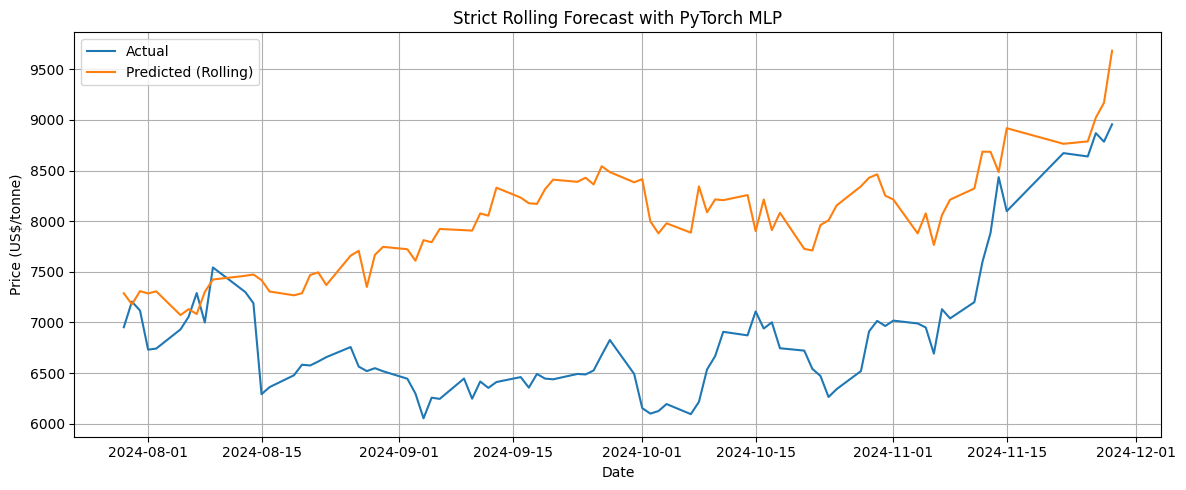

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

actual = test_df['Price'].values[:len(preds)]

rmse = np.sqrt(mean_squared_error(actual, preds))
mae = mean_absolute_error(actual, preds)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'].values[:len(preds)], actual, label='Actual')
plt.plot(test_df['Date'].values[:len(preds)], preds, label='Predicted (Rolling)')
plt.title("Strict Rolling Forecast with PyTorch MLP")
plt.xlabel("Date")
plt.ylabel("Price (US$/tonne)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
import numpy as np
features = ['Price', 'PRCP', 'TAVG', 'TMAX', 'TMIN']
lag = 7

X_train, y_train = [], []
train_array = train_df[features].values

for i in range(lag, len(train_array)):
    window = train_array[i-lag:i].flatten()
    target = train_array[i][0]
    X_train.append(window)
    y_train.append(target)

X_train = np.array(X_train)
y_train = np.array(y_train)

In [22]:
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train.reshape(-1, 1))

X_train_scaled = scaler_X.transform(X_train)
y_train_scaled = scaler_y.transform(y_train.reshape(-1, 1))
X_lstm = X_train_scaled.reshape(-1, lag, len(features))  # [N, 7, 5]
y_lstm = y_train_scaled                                  # [N, 1]

X_tensor = torch.tensor(X_lstm, dtype=torch.float32)
y_tensor = torch.tensor(y_lstm, dtype=torch.float32)

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [23]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        output, _ = self.lstm(x)         # output: [batch, seq, hidden]
        last_output = output[:, -1, :]
        return self.fc(last_output)

model = LSTMRegressor(input_size=len(features))


In [24]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(100):
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


[Epoch 0] Loss: 0.0129
[Epoch 10] Loss: 0.0029
[Epoch 20] Loss: 0.0134
[Epoch 30] Loss: 0.0024
[Epoch 40] Loss: 0.0074
[Epoch 50] Loss: 0.0014
[Epoch 60] Loss: 0.0015
[Epoch 70] Loss: 0.0016
[Epoch 80] Loss: 0.0007
[Epoch 90] Loss: 0.0006


In [25]:
model.eval()
test_array = test_df[features].values
history = train_df[features].values[-lag:].tolist()
preds = []

with torch.no_grad():
    for i in range(len(test_array)):
        window = np.array(history).reshape(1, lag, len(features))
        window_scaled = scaler_X.transform(window.reshape(1, -1))\
                                .reshape(1, lag, len(features))

        x_tensor = torch.tensor(window_scaled, dtype=torch.float32)
        y_pred_scaled = model(x_tensor).numpy()
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0, 0]
        preds.append(y_pred)

        next_weather = test_array[i][1:]
        next_row = [y_pred] + next_weather.tolist()
        history.pop(0)
        history.append(next_row)


RMSE: 867.62, MAE: 748.95


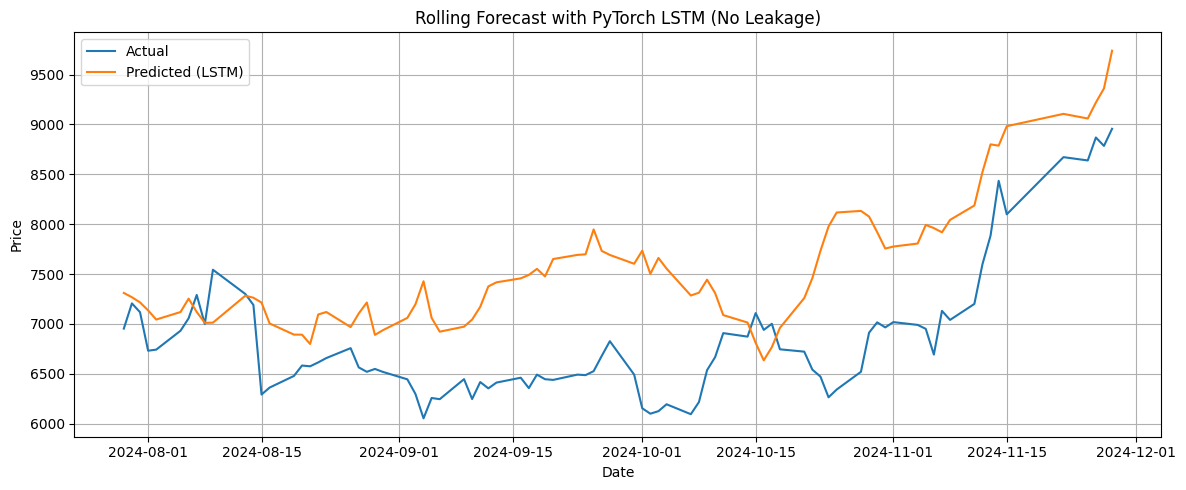

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

actual = test_df['Price'].values[:len(preds)]

rmse = np.sqrt(mean_squared_error(actual, preds))
mae = mean_absolute_error(actual, preds)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'].values[:len(preds)], actual, label='Actual')
plt.plot(test_df['Date'].values[:len(preds)], preds, label='Predicted (LSTM)')
plt.title("Rolling Forecast with PyTorch LSTM (No Leakage)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [55]:
import pandas as pd

wind = pd.read_csv("/content/drive/MyDrive/wind.csv")
wind['Date'] = pd.to_datetime(wind['valid_time'])

print(wind.columns)


Index(['valid_time', 'u10', 'v10', 'latitude', 'longitude', 'Date'], dtype='object')


In [56]:
wind_daily = wind.groupby('Date')[['u10', 'v10']].mean().reset_index()

wind_daily['u10'] = wind_daily['u10'].interpolate().fillna(method='ffill').fillna(method='bfill')
wind_daily['v10'] = wind_daily['v10'].interpolate().fillna(method='ffill').fillna(method='bfill')

<ipython-input-56-4a15796b7550>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wind_daily['u10'] = wind_daily['u10'].interpolate().fillna(method='ffill').fillna(method='bfill')
<ipython-input-56-4a15796b7550>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  wind_daily['v10'] = wind_daily['v10'].interpolate().fillna(method='ffill').fillna(method='bfill')


In [57]:
cocoa = pd.read_csv("cleaned_cocoa_data.csv")
cocoa['Date'] = pd.to_datetime(cocoa['Date'])

merged = pd.merge(cocoa, wind_daily, how='left', on='Date')
merged = merged.dropna().reset_index(drop=True)
merged.to_csv("merged_with_wind_uv.csv", index=False)


In [58]:
import pandas as pd
import numpy as np


df = pd.read_csv("merged_with_wind_uv.csv")
df['Date'] = pd.to_datetime(df['Date'])


target_col = 'Price'
features = ['Price', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'u10', 'v10']
lag = 7


In [59]:

df = df.set_index('Date').resample('D').mean().dropna().reset_index()
cutoff = df['Date'].max() - pd.DateOffset(months=4)
train_df = df[df['Date'] < cutoff]
test_df = df[df['Date'] >= cutoff]



In [60]:
X_train, y_train = [], []
train_array = train_df[features].values

for i in range(lag, len(train_array)):
    X_train.append(train_array[i-lag:i])
    y_train.append(train_array[i][0])

X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1, 1)


In [61]:
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_2d = X_train.reshape(-1, lag * len(features))
X_train_scaled = scaler_X.fit_transform(X_train_2d).reshape(-1, lag, len(features))

y_train_scaled = scaler_y.fit_transform(y_train)


In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = LSTMRegressor(input_dim=len(features))
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


In [63]:
for epoch in range(100):
    model.train()
    for xb, yb in loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Loss: {loss.item():.4f}")


[Epoch 0] Loss: 0.0018
[Epoch 10] Loss: 0.0014
[Epoch 20] Loss: 0.0045
[Epoch 30] Loss: 0.0030
[Epoch 40] Loss: 0.0019
[Epoch 50] Loss: 0.0067
[Epoch 60] Loss: 0.0029
[Epoch 70] Loss: 0.0028
[Epoch 80] Loss: 0.0018
[Epoch 90] Loss: 0.0039


In [64]:
model.eval()
test_array = test_df[features].values
history = train_df[features].values[-lag:].tolist()
preds = []

with torch.no_grad():
    for i in range(len(test_array)):
        window = np.array(history).reshape(1, lag, len(features))
        window_scaled = scaler_X.transform(window.reshape(1, -1)).reshape(1, lag, len(features))

        x_tensor = torch.tensor(window_scaled, dtype=torch.float32)
        y_pred_scaled = model(x_tensor).numpy()
        y_pred = scaler_y.inverse_transform(y_pred_scaled)[0, 0]
        preds.append(y_pred)

        next_weather = test_array[i][1:]
        next_row = [y_pred] + next_weather.tolist()
        history.pop(0)
        history.append(next_row)


RMSE: 546.90, MAE: 449.73


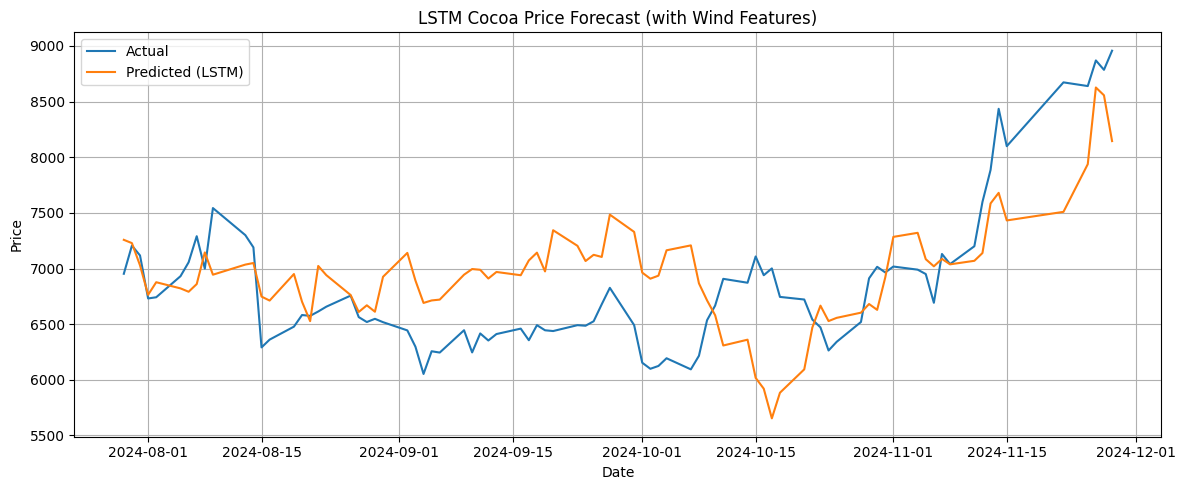

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

actual = test_df['Price'].values[:len(preds)]

rmse = np.sqrt(mean_squared_error(actual, preds))
mae = mean_absolute_error(actual, preds)
print(f"RMSE: {rmse:.2f}, MAE: {mae:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(test_df['Date'].values[:len(preds)], actual, label='Actual')
plt.plot(test_df['Date'].values[:len(preds)], preds, label='Predicted (LSTM)')
plt.title("LSTM Cocoa Price Forecast (with Wind Features)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
